# Main Comparison Plots

In [1]:
!pip install jsonlines
!ls
import glob
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from preprocess import read_jsonlines_file, average_results, read_sota

SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


1m_output.jsonl			      output_static_21.jsonl
docker_run.sh			      output_static_22.jsonl
dynamic.pdf			      output_static_23.jsonl
flexible_bitrate.ipynb		      output_static_24.jsonl
graph_distances.pdf		      output_static_31.jsonl
graph_sota.pdf			      output_static_32.jsonl
iou_train.json			      output_static_33.jsonl
iou_val.json			      output_static_34.jsonl
new				      output_static_41.jsonl
office.pdf			      output_static_42.jsonl
output_distance_1_deadline_300.jsonl  output_static_43.jsonl
output_distance_1_deadline_600.jsonl  output_static_44.jsonl
output_distance_1.jsonl		      plots.ipynb
output_distance_3_deadline_300.jsonl  preprocess.py
output_distance_3_deadline_600.jsonl  __pycache__
output_distance_5_deadline_300.jsonl  results_dynamic_bitrate.csv
output_distance_5_deadline_600.jsonl  rpi4_cpus4.csv
output_distance_7_deadline_300.jsonl  sample_analysis.ipynb
output_distance_7_deadline_600.jsonl  sample_ap_bandwidth.pdf
output_distance_9_deadline_300.jsonl  sa

In [2]:
df = read_sota()
print(df)

                   ms     KB   mAP
model                             
ours_11            66    6.9  14.5
ours_14            66   27.6  34.3
ours_22           133   13.8  29.4
ours_24           137   27.6  36.1
ours_33           202   20.7  34.2
ours_34           198   27.6  36.4
ours_44           263   27.6  36.8
lee2021_3         267   30.5  36.8
lee2021_5         341   16.2  36.7
lee2021_7         407    8.8  36.5
lee2021_10        456    4.7  36.4
matsubara2022_1  1265  180.0  36.1
matsubara2022_2  1265   90.0  35.9
matsubara2022_3  1265   23.0  34.0
matsubara2022_4  1264   15.0  29.5
matsubara2022_5  1264    8.0  26.0
assine2022a_25   1404  110.0  31.6
assine2022a_50   2240  220.0  37.8
assine2022a_75   2959  330.0  39.9
assine2022a_100  4036  440.0  39.6


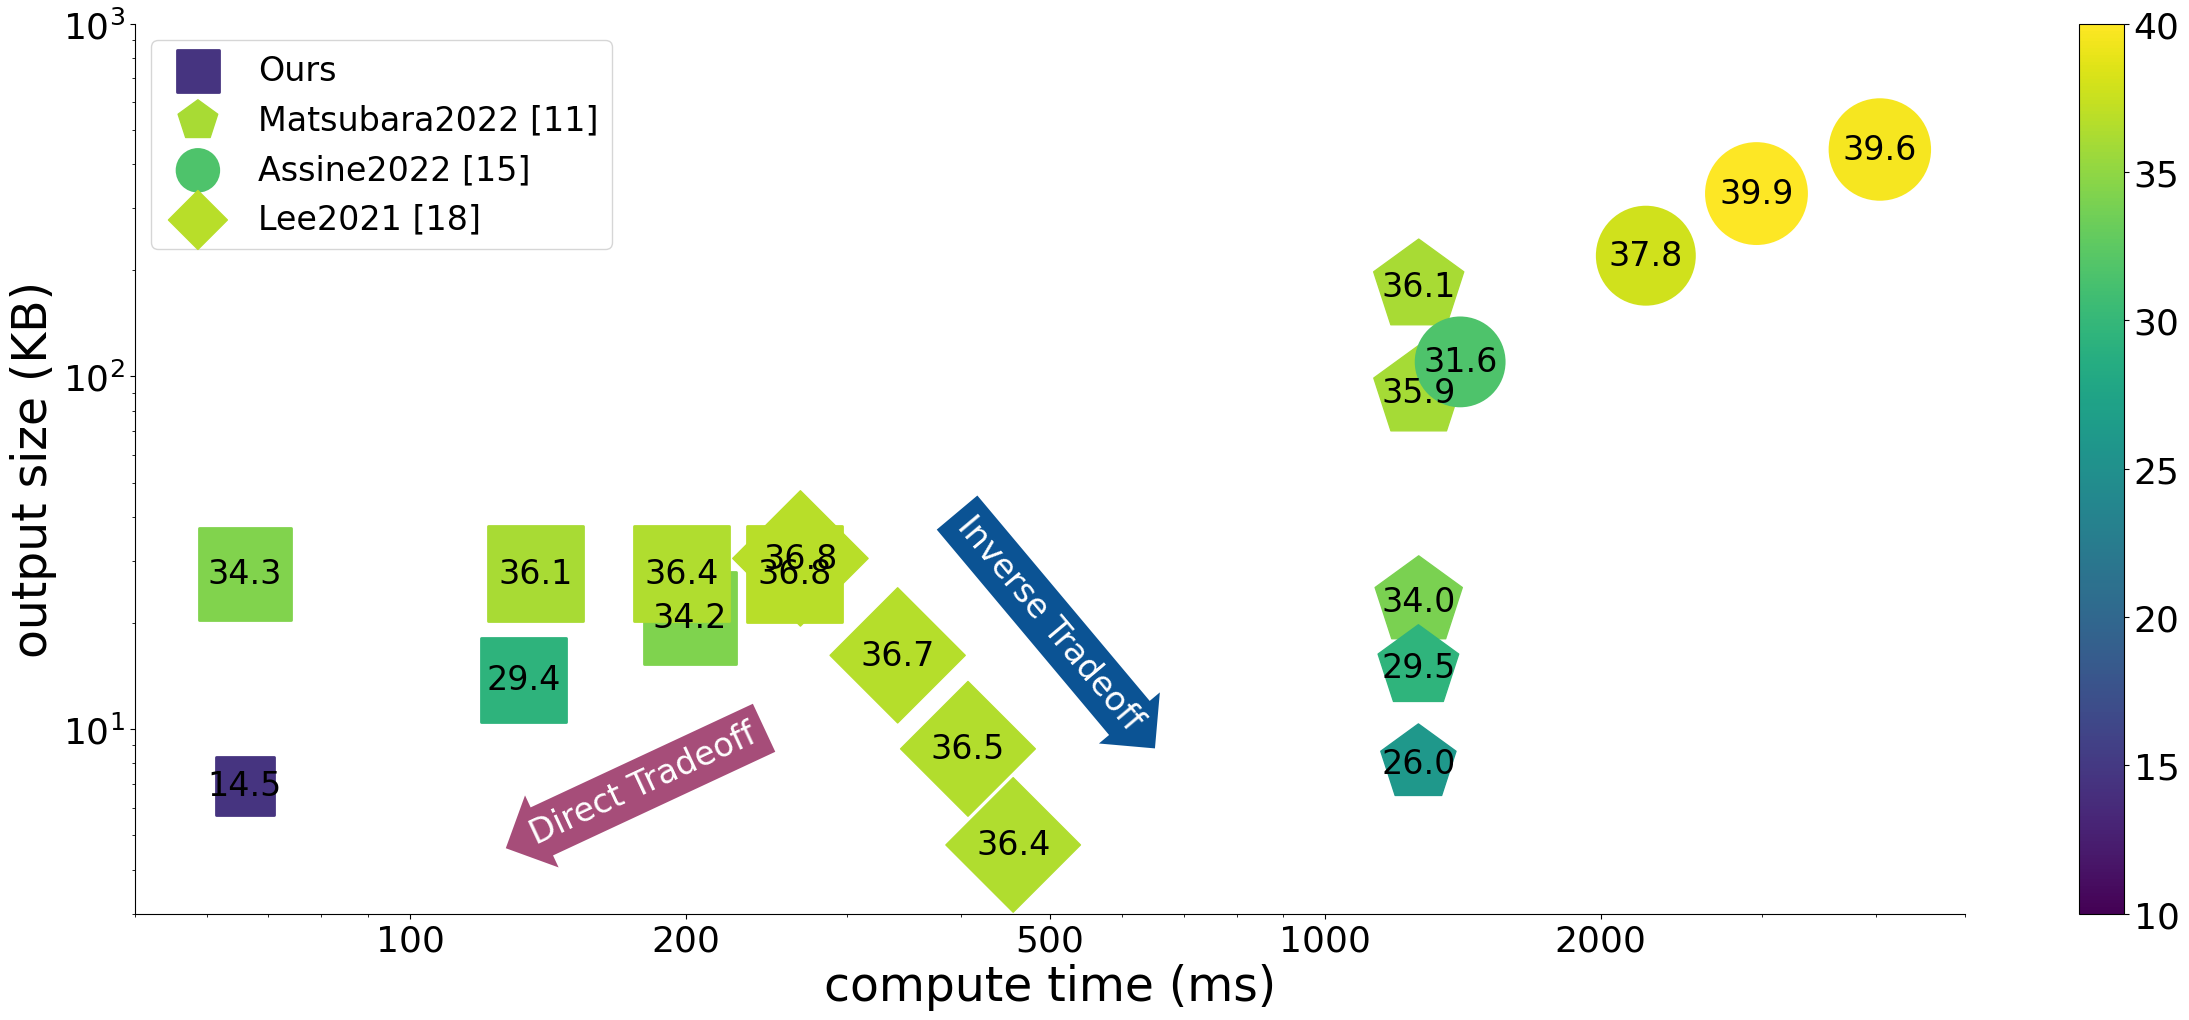

In [3]:
df = read_sota()

SMALL_SIZE = 26
MEDIUM_SIZE = 30
BIGGER_SIZE = 34

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



def plot(ax, name, color='blue', marker='o', configurable=False, label=""):
    a = df[df.index.str.contains(name)]
    bw = a['KB'].values
    latency = a['ms'].values
    mAP = a['mAP'].values
    
    z = 90*(mAP**1.1)
    z_label = ["{:2.1f}".format(m) for m in mAP]
    
    vmin=10.0
    vmax=40.0
    
    if configurable:
         axi = ax.scatter(latency, bw, s=z, marker=marker, alpha=1.0, 
                    label=label, linewidth=2,
#                     edgecolor='black',
                    c=mAP, cmap='viridis', vmin=vmin, vmax=vmax)
    else:
        axi = ax.scatter(latency, bw, s=z, marker=marker, alpha=1.0,
                   label=label,
#                    edgecolor='black',
                   c=mAP, cmap='viridis', vmin=vmin, vmax=vmax)
    for i in range(len(mAP)):
        ax.annotate(z_label[i], ( latency[i], bw[i]), ha='center', va='center', fontsize=24, color='black')

    return axi

fig = plt.figure(figsize=(22,10))
ax = fig.add_subplot(111)
ax.set_xlabel('compute time (ms)')
ax.set_ylabel('output size (KB)')
ax.set_xscale('log')
ax.set_yscale('log')

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

f = "literature_comparison/literature.csv"
df.columns = df.columns.str.replace(' ', '')
plot(ax, "ours", color='red', marker="s", configurable=True, label="Ours")
plot(ax, "matsubara2022", color='blue', marker="p", label="Matsubara2022 [11]")
plot(ax, "assine2022", color="#A8127D", marker="o", configurable=True, label="Assine2022 [15]")
axi = plot(ax, "lee2021", color='cyan', marker='D', label="Lee2021 [18]")





# ADD ARROWS
bbox_props = dict(boxstyle="rarrow", fc="#0b5394", ec="b", lw=0)
t = ax.text(500, 2e1, "Inverse Tradeoff", ha="center", va="center", rotation=-50,
            size=24, color="white",
            bbox=bbox_props)
bbox_props = dict(boxstyle="larrow", fc="#a64d79", ec="b", lw=0)
t = ax.text(180, 7, "Direct Tradeoff", ha="center", va="center", rotation=25,
            size=24, color="white",
            bbox=bbox_props)

# LEGEND
legend_properties = {'weight':'normal', 'size': 24}
lgnd = ax.legend(fontsize=15,  prop=legend_properties, 
                 loc='upper left')
for i in range(4):
    lgnd.legendHandles[i]._sizes = [0.9e3]
#     lgnd.legendHandles[i].set_color('black')
#     lgnd.legendHandles[i].set_facecolor('white')

ax.set_xlim(50, 5e3)
ax.set_ylim(3, 1e3)
fig.colorbar(axi)

ax.set_xticks([1e2, 2e2, 5e2, 1e3, 2e3])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
plt.subplots_adjust(top = 0.97, bottom = .08, right = 1.1, left = .06, hspace = 0, wspace = 0.15)
plt.savefig("graph_sota.pdf", dpi=500, bbox_inches='tight')

# Switching Time Chart

In [4]:

file_list = glob.glob("switching*")

columns=['name', 'num_configs', "ram(MB)", "disk_load(ms)", "warmup(ms)"]
num_configs_dict = {
    "assine2022b": 16,
    "assine2022a": 12,
    "matsubara2022": 4,
    "lee2021": 5,
}

rows = []

for file in file_list:
    with open(file, "r") as fp:
        data = json.load(fp)
        name = file.split('switching_result_')[1].split(".json")[0]
        num_configs = num_configs_dict[name]
        ram = data["ram"]*1000
        disk_load = sum([l["disk_load"] for l in data["lists"]])
        warmup = sum([l["warmup"] for l in data["lists"]])
        row = [name, num_configs, ram, disk_load, warmup]
        rows.append(row)
        
    

df = pd.DataFrame(rows, columns=columns)
df = df.set_index("name")
df = df.round(1)
print(df)
# print(df.to_latex())

               num_configs  ram(MB)  disk_load(ms)  warmup(ms)
name                                                          
assine2022b             16     85.7          954.0      1811.5
assine2022a             12    204.9         1207.0      9913.6
matsubara2022            4    239.9          709.9     12785.1
lee2021                  5    153.4         1264.5      5045.5


## Dynamic Behaviour


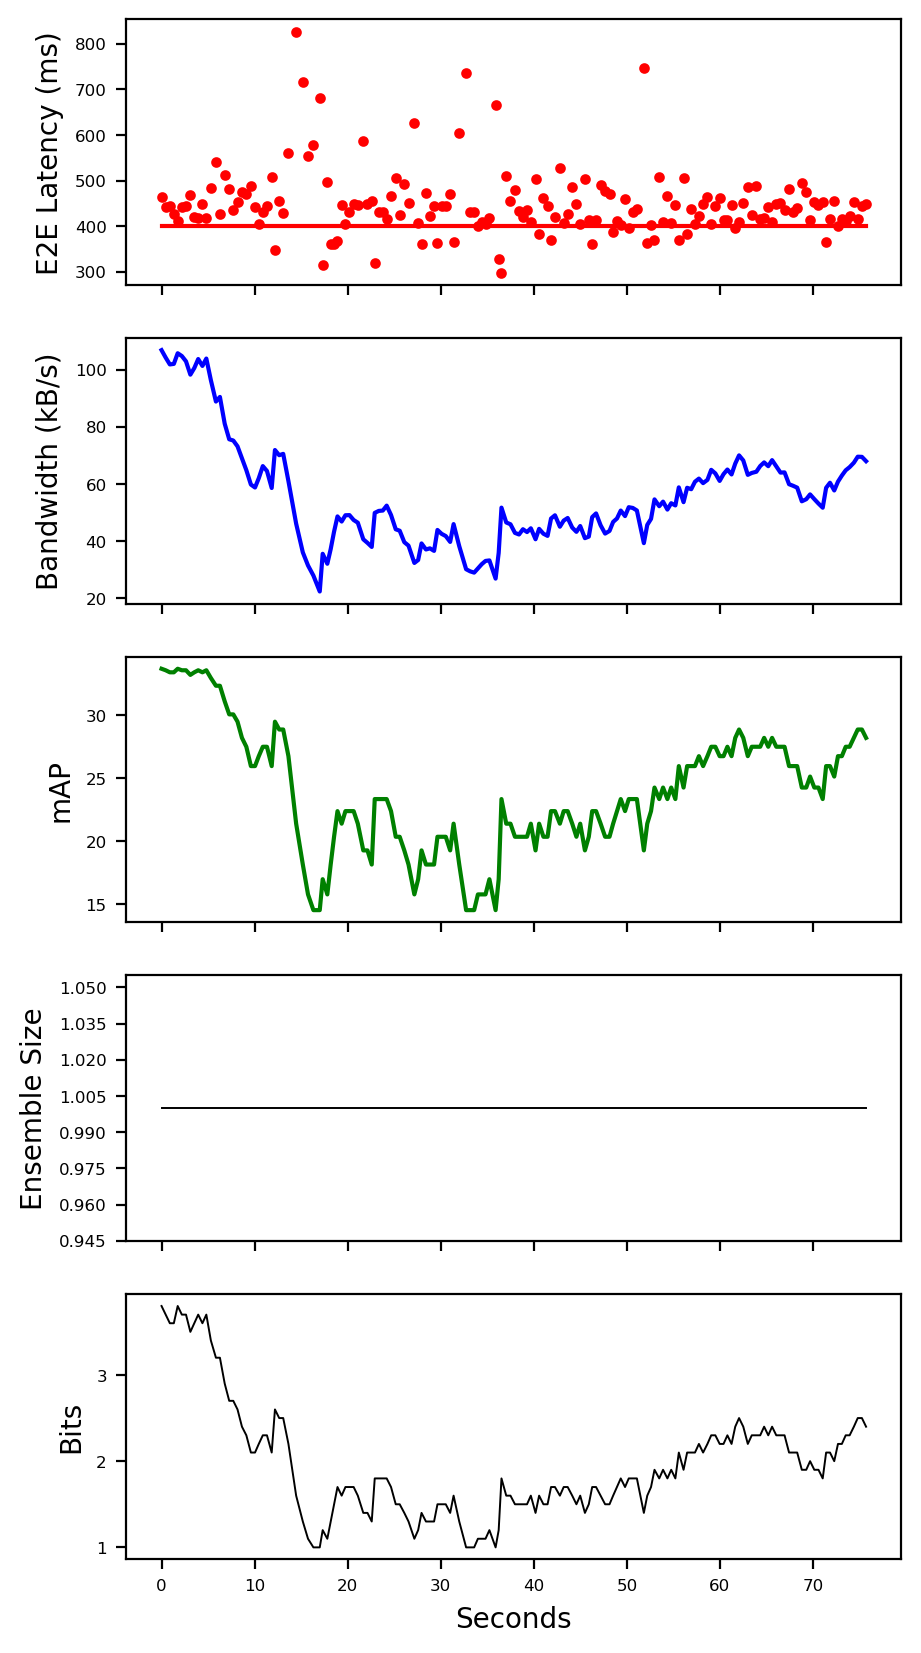

In [16]:
from matplotlib.ticker import MaxNLocator
SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

results = read_jsonlines_file('output_Test.jsonl')
fig, ax = plt.subplots(5, 1, figsize=(5, 10), dpi=200)


for a in fig.get_axes():
    a.label_outer()
    
p0 = ax[0].scatter(results["time"], results["e2e"], s=8, color='r', label="E2E Latency")
# p0 = ax[0].plot(time, e2e, "r-", linewidth=0.7)
p0 = ax[0].plot(results["time"], results["deadline"], "r-")
p1 = ax[1].plot(results["time"], results["bw"], "b-", label="Bandwidth(kB/s)")
p2 = ax[2].plot(results["time"], results["mAP"], "g-", label="mAP")
p3 = ax[3].plot(results["time"], results["compute"], linewidth=0.7, color="black", label="mAP")
p4 = ax[4].plot(results["time"], results["bits"], linewidth=0.7, color="black", label="mAP")


ax[3].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[4].yaxis.set_major_locator(MaxNLocator(integer=True))

ax[0].set_ylabel("E2E Latency (ms)")
ax[1].set_ylabel("Bandwidth (kB/s)")
ax[2].set_ylabel("mAP")
ax[3].set_ylabel("Ensemble Size")
ax[4].set_ylabel("Bits")
ax[4].set_xlabel("Seconds")

plt.savefig("dynamic.pdf")

# Dynamic - Fixed Distance

In [9]:
SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



import itertools
distances = [1, 3, 5, 7, 9]
deadlines = [300, 600]
configs = itertools.product(distances, deadlines)

df = pd.DataFrame()
for c in configs:
    try:
        results = read_jsonlines_file(f'output_distance_{c[0]}_deadline_{c[1]}.jsonl')
        results = average_results(results)
        results["label"] = f"{c[0]}m"
        df = df.append(results, ignore_index=True)
    except:
        pass

df = df.sort_values("deadline")
df1 = df[df["deadline"] == 300.0]
df2 = df[df["deadline"] == 600.0]
print(df1)
# df = df.set_index("label")


width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=200)


def plotdf(df, ax):
    rects = ax.bar(df1["label"], df["encoder_time"], width, label='encoder', zorder=3, color='#89B67E')
    ax.bar(df["label"], df["transfer_time"], width, 
           bottom=df["encoder_time"], label='communication', zorder=3, color='#D19F33')
    ax.bar(df["label"], df["decoder_time"], width,
           bottom=df["encoder_time"]+df["transfer_time"], label='decoder', zorder=3, color='#E17879')

    # Add counts above the two bar graphs
    for i, row in enumerate(df.iterrows()):
        row = row[1]
        height = row["encoder_time"]+row["transfer_time"]+row["decoder_time"]
        rect = rects[i]
        ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{row["mAP"]}', 
                ha='center', va='bottom', zorder=3)

    ax.set_ylim(0, 600)

    # plt.axhline(y = 300, color = 'black', linestyle = '--')
    # plt.axhline(y = 600, color = 'black', linestyle = '--')



ax[0].grid(axis='y',linestyle='--', zorder=0)
ax[1].grid(axis='y',linestyle='--', zorder=0)
plotdf(df1, ax[0])
plotdf(df2, ax[1])
ax[0].set_ylabel("Round Trip Time (ms)")
ax[0].legend(loc='upper left')
ax[1].tick_params(axis=u'both', which=u'both',length=0)


ax[0].set_xlabel("Deadline 300ms")
ax[1].set_xlabel("Deadline 600ms")

plt.setp(ax[1].get_yticklabels(), visible=False)
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig("graph_distances.pdf", dpi=500,bbox_inches='tight')



KeyError: 'deadline'

In [ ]:
for a in df.iterrows():
    print(a)

# Fixed Mode - Fixed Distance

In [ ]:
modes = [11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34, 41, 42, 43, 44]

df = pd.DataFrame()

for mode in modes:
    results = read_jsonlines_file(f'output_static_{mode}.jsonl')
    results = average_results(results)
    df = df.append(results, ignore_index=True)

df['mode'] = df['mode'].astype(int)

df = df.drop(['time', 'deadline', "bw", "mode"], axis=1)
df['compute'] = df['compute'].astype(int)
df['bits'] = df['bits'].astype(int)


df = df.sort_values("e2e")
# df = df.set_index('e2e')
df = df.drop(["encoder_time", "decoder_time", "transfer_time"], axis=1)

df = df.transpose()
print(df.to_latex())